### Libraries

In [1]:
# All the imports you will need in the whole lab
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
import os
from skimage import io
from isodata import isodata_classification
from sklearn.cluster import KMeans, BisectingKMeans, MiniBatchKMeans
import numpy as np
from PIL import Image
from skimage.color import rgb2gray
from skimage.transform import  resize



### ISODATA results

Isodata(info): Starting algorithm with {k} classes
Isodata(info): Finished with 5 classes
Isodata(info): Number of Iterations: 4
found 5 clusters


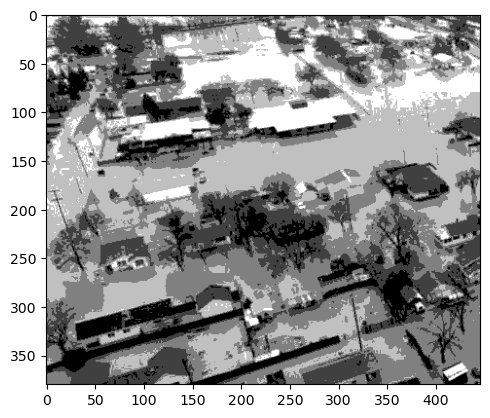

In [2]:
img = cv2.imread("./dataset/flooded/455.jpg", cv2.IMREAD_GRAYSCALE)

image_class = isodata_classification(img)
num_clusters = image_class.max()+1
print(f"found {num_clusters} clusters")
for classnum in range(1,num_clusters):
    image_class[image_class == classnum] = classnum*20

plt.imshow(image_class, cmap='gray')
plt.show()

### Clustering With Textures

In [3]:
def get_glcm_features(gray_scale_img):
    """
    Given a grayscale image with graylevels from 0 - 255, this function returns the contrast
    and the homogeneity features of the image with the help of GLCM
    """
    co = graycomatrix(gray_scale_img,[3],[0])
    # Tip: Make sure you understand the input-output of everything you write, 
    # not doing that results in bugs that make you believe the lab is long
    
    return graycoprops(co,prop="contrast"),  graycoprops(co,prop="homogeneity")

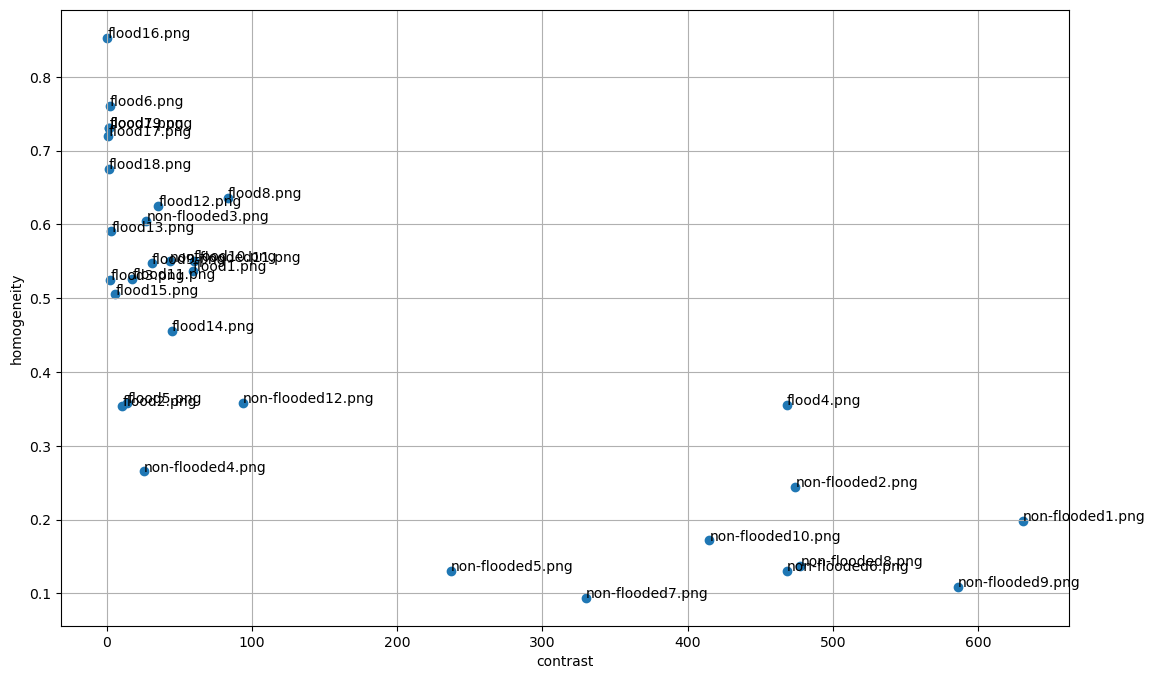

In [4]:
# You don't need to understand how this function works
def get_fname_images_tuple(directory):
    fnames = os.listdir(directory)
    to_return = []
    for fn in fnames:
        path = os.path.join(directory, fn)
        gray_scale_image = (rgb2gray(io.imread(path)[:,:,:3]) * 255).astype(np.uint8)
        to_return.append((fn, gray_scale_image))
    return to_return

# You don't need to understand how this function works
def plot_2d_features_with_names(names_fts_list, xlabel, ylabel):
    x = [names_fts[1][0] for names_fts in names_fts_list]
    y = [names_fts[1][1] for names_fts in names_fts_list]
    txts = [names_fts[0] for names_fts in names_fts_list]
    
    fig, ax = plt.subplots()
    ax.scatter(x, y)

    for i, txt in enumerate(txts):
        ax.annotate(txt, (x[i], y[i]))
    ax.grid()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig = plt.gcf()
    fig.set_size_inches(13, 8)
    
    
fn_img_list = get_fname_images_tuple(r'imgs_patches')

fn_ft_list = []
for fn, img in fn_img_list:
    fn_ft_list.append((fn, get_glcm_features(img)))
    
plot_2d_features_with_names(fn_ft_list, 'contrast', 'homogeneity')

In [5]:
def classify_patch(contrast, homogeneity):
    """
    Given the contrast and homogeneity values of a certain image patch, this function 
    will return the class of the patch, i.e either 'flooded' or 'non flooded'
    """
    if homogeneity >= .5:
        return 'flooded'
    if contrast <= 100 and homogeneity >= .3:
        return 'flooded'
    else:
        return 'non-flooded'


def segment_img(image):
    img = image.copy()
    patch_height = patch_width = 8

    # loop on the image patch by patch
    for i in range(0, img.shape[0], patch_height):
        for j in range(0, img.shape[1], patch_width):
            patch = img[i:i+patch_height, j:j+patch_width]

            patch_grayscale = (rgb2gray(patch) * 255).astype(np.uint8)

            contrast, homogeneity = get_glcm_features(patch_grayscale)
            classification = classify_patch(contrast, homogeneity)

            if classification == 'flooded':
                patch[:, :, 0] = 255
            elif classification == 'non-flooded':
                patch[:, :, 1] = 255
            else:
                patch[:, :, 2] = 255

    return img

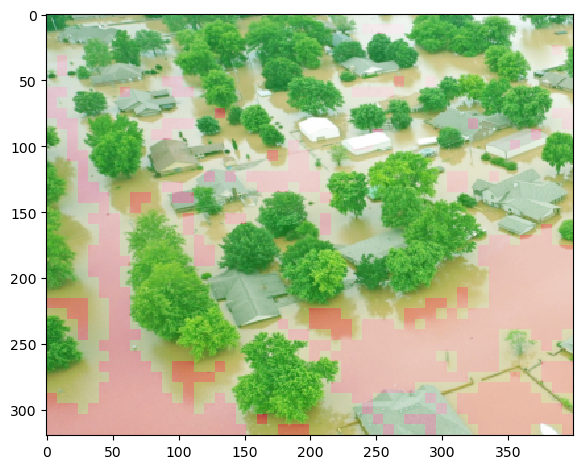

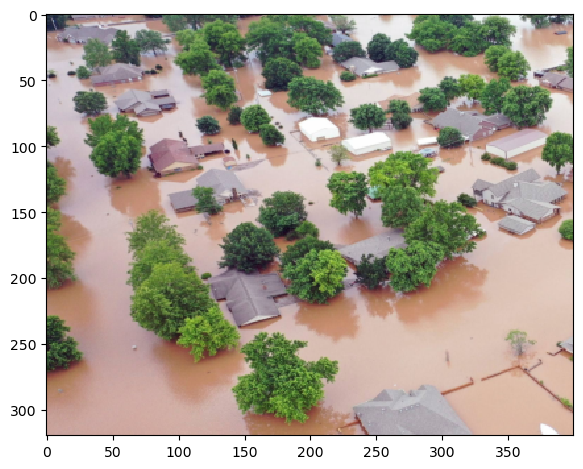

In [6]:
img = cv2.imread('./dataset/flooded/0.jpg')
img = resize(img, (320, 400, 3), anti_aliasing=True, preserve_range=True).astype(np.uint8)
segmented_image = segment_img(img)

original = Image.fromarray(img)
clustered = Image.fromarray(segmented_image)

original = original.convert("RGBA")
clustered = clustered.convert("RGBA")

blended = Image.blend(original, clustered, alpha=.4)

io.imshow(np.asarray(blended))
io.show()
io.imshow(img)
io.show()

### KMeans

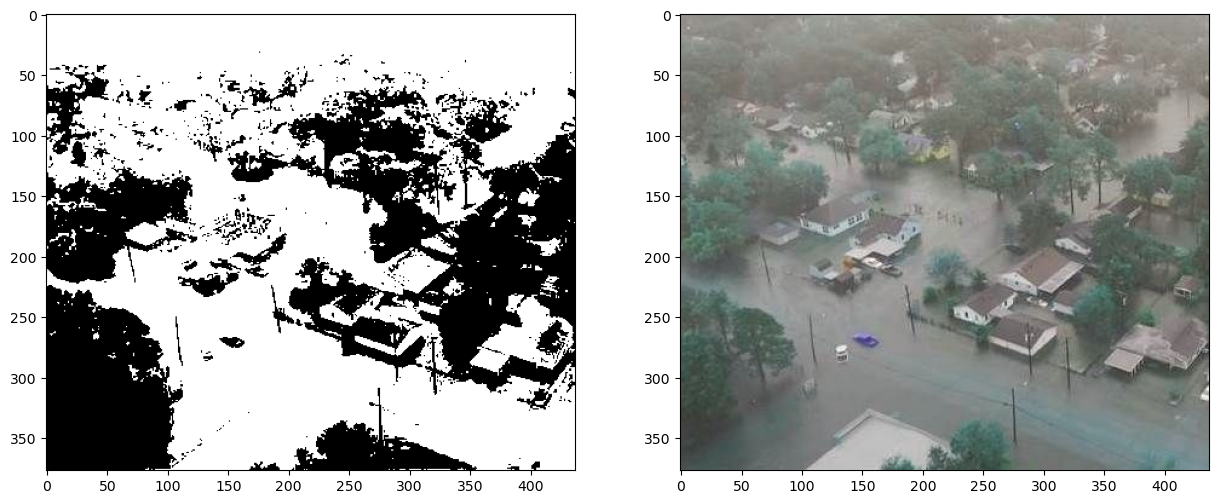

In [7]:
img = cv2.imread('./dataset/flooded/12.jpg')
other_space = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
kmeans = MiniBatchKMeans(n_clusters=2, random_state=42, batch_size=100, init='k-means++', reassignment_ratio=0, tol=1e-2)
labels =  kmeans.fit_predict(other_space.reshape((-1,3)))

labels = 255 - labels.reshape(img.shape[:2])*255
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.imshow(labels, cmap='gray')
ax2.imshow(img)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import cv2


In [ ]:
train_df = tf.keras.utils.image_dataset_from_directory(
    image_size=(256, 256),
    directory="dataset", validation_split=0.2, subset="training", seed=123, batch_size=32)

valid_df = tf.keras.utils.image_dataset_from_directory(
    image_size=(256, 256),
    directory="dataset", validation_split=0.2, subset="validation", seed=123, batch_size=32)

# Set up the GAIN model
num_classes = 2  # Change this to the number of classes in your dataset
base_model = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_shape=(256,256,3))
base_model.trainable = False

flatten_layer = tf.keras.layers.Flatten()
dense_layer_1 = tf.keras.layers.Dense(50, activation='relu')
dense_layer_2 = tf.keras.layers.Dense(20, activation='relu')
predition_layer = tf.keras.layers.Dense(1, activation='softmax')

model = tf.keras.models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    predition_layer
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
epochs = 20
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)]
history = model.fit(train_df,
                    epochs=epochs,
                    validation_data=valid_df,
                    callbacks=callbacks)

print(history.history)